# TDA & Deep Learning Project Report

Floran DEFOSSEZ
Gatien Chopard
Sebastien ROIG

Ce notebook a pour objectif de synthétiser et illustrer les concepts et résultats de l'article de Bertand Michel and Frédéric Chazal "An Introduction to Topological Data Analysis: Fundamental and Practical Aspects for Data Scientists". Nous allons uliliser pour cela la librairie GUDHI.

# Simplicial Complexes

TODO : définition

Afin de d'analyser le structure topologique d'un nuage de point, il est possible de se servir d'un complexe simplicial construit à partir de ces données. Il existe de nombreuses méthodes de construction, nous allons vous présenter les deux principales : Le compexe de Vietoris–Rips et le compexe de Čech

#### The Vietoris-Rips

In [31]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import utils
import matplotlib as ma
%matplotlib inline


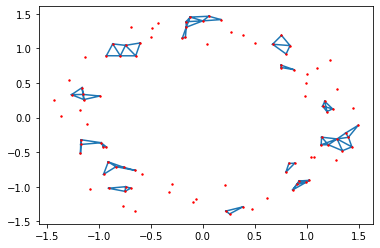

In [52]:

alpha = 0.1
points = utils.anulus(100)

rips_complex = gd.RipsComplex(points=points)
simplex_tree = rips_complex.create_simplex_tree(2)
triangles = np.array([x[0] for x in simplex_tree.get_skeleton(2) if len(x[0]) == 3 and x[1] <= 2*alpha])
plt.triplot(points[:,0], points[:,1], triangles = triangles)
plt.scatter(points[:,0],points[:,1],s=2,c='r')
plt.show()





# The Mapper Algorithm

# Geometric Reconstruction and Homology Inference

# Persistent Homology

# Statistical Aspects of Persistent Homology